<a href="https://colab.research.google.com/github/luigiselmi/timeseries/blob/main/lstm_for_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM for Time Series

The neural network models, based on fully connected layers, that we used in previous examples to forecast the traffic volume do not consider the order of the observations. The observations are implicitely assumed to be indipendent. We know that an observation made at time $t$ depends on past observations. A neural network based on a stack of fully connected layers is not able to memorize and use previous information. For this reason other architectures have been developed to handle ordered sequences of data.

## Recurrent Neural Network (RNN)
A RNN is a model in which each unit of a layer takes as input an element of the input sequence and the output of the previous unit. The output of each unit is copied and passed to the next unit as shown in the figure. The number of units depends on the length of the sequences but is usually set to a multiple of 2, e.g. 32. The number of RNN layers depends on the complexity of the sequence.

![RNN](https://github.com/luigiselmi/timeseries/blob/main/images/recurrent_neural_network.svg?raw=1)

## Long Short-Term Memory Network (LSTM)
A LSTM is a type of RNN that adds a cell state as input to the element of input sequence and the output of the previous unit. A LSTM unit apply several activation functions and operations to those inputs as shown in the figure. These operations allow the model to learn which elements in the sequence are more useful to forecast the next element. All the functional element within a LSTM unit are implemented as neural network layers so that they can be trained using the same algorithms.

![LSTM](https://github.com/luigiselmi/timeseries/blob/main/images/long_short-term_memory.svg?raw=1)

In our case, with the traffic data, we will use sequences of 24 hourly observations. Each element $X_t$ of the input sequence is a set of feature values: cloud coverage, day_sin, day_cos, and temperature. The corresponding label is the traffic volume.

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
import keras
from keras import layers
print('NumPy version: %s'%np.__version__)
print('Pandas version: %s'%pd.__version__)
print('Matplotlib version: %s'%mpl.__version__)
print('TensorFlow version: %s'%tf.__version__)
print('Keras version: %s'%keras.__version__)

NumPy version: 1.26.4
Pandas version: 2.2.2
Matplotlib version: 3.10.0
TensorFlow version: 2.18.0
Keras version: 3.8.0


In [2]:
def download_data(url):
  r = requests.get(url)
  data_path = url.rsplit('/')[-1]
  with open(data_path, 'wb') as f:
    f.write(r.content)
  return data_path

In [3]:
train_url = 'https://raw.githubusercontent.com/luigiselmi/timeseries/main/data/metro_interstate_traffic/train.csv'
val_url = 'https://raw.githubusercontent.com/luigiselmi/timeseries/main/data/metro_interstate_traffic/val.csv'
test_url = 'https://raw.githubusercontent.com/luigiselmi/timeseries/main/data/metro_interstate_traffic/test.csv'
train_data = download_data(train_url)
val_data = download_data(val_url)
test_data = download_data(test_url)
train_df = pd.read_csv(train_data, index_col=0)
val_df = pd.read_csv(val_data, index_col=0)
test_df = pd.read_csv(test_data, index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


We use the same DataWindow class used in other notebooks for the traffic datasets to define the data structure to train the LSTM models.  

In [4]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        '''
        This function separates inputs and labels from the features.
        '''
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        '''
        The function plots the model's predictions for three data windows
        '''
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        '''
        This function is based on a Keras function to create batches of data by sliding windows of inputs and lables from the train, validation, and test sets.
        The slide is set with the sequence_stride argument and it is set to 1. The data windows are shuffled but the order within each window is preserved.
        '''
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

We reuse the same function to compile and fit the models as well. The loss function is the mean squared error and the metric is the mean absolute error.

In [5]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=keras.losses.MeanSquaredError(),
                  optimizer=keras.optimizers.Adam(),
                  metrics=[keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

## Single-step LSTM model
With this model we use sequences of 24 hours of observations to train a LSTM model to forecast the traffic volume one hour in the future.

In [8]:
train_df.columns

Index(['temp', 'clouds_all', 'traffic_volume', 'day_sin', 'day_cos'], dtype='object')

We use a data window with 24 hours observations, 24 hours labels and shift 1 step since we want to forecast the traffic volume only one hour

In [6]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume'])
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

Our model is a sequential model with a [LSTM layer](https://keras.io/api/layers/recurrent_layers/lstm/) with 32 units followed by a fully connected layer with one unit. The number of units of the LSTM layer is set depending on the length of the sequences and is usually set to a power of 2 for computational efficiency when using a GPU.

In [7]:
lstm_model = keras.Sequential([
    layers.LSTM(32, return_sequences=True),
    layers.Dense(units=1)
])

In [9]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0358 - mean_absolute_error: 0.1386 - val_loss: 0.0075 - val_mean_absolute_error: 0.0628
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.0064 - mean_absolute_error: 0.0576 - val_loss: 0.0046 - val_mean_absolute_error: 0.0487
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0046 - mean_absolute_error: 0.0486 - val_loss: 0.0040 - val_mean_absolute_error: 0.0452
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0040 - mean_absolute_error: 0.0447 - val_loss: 0.0035 - val_mean_absolute_error: 0.0415
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0037 - mean_absolute_error: 0.0424 - val_loss: 0.0031 - val_mean_absolute_error: 0.0392
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0034 - mean_absolute_error: 0.0402 - val_loss: 0.0029 - val_mean_absolute_error: 0.0380
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0032 - mean_absolute_error: 

In [15]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 32)              │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 24, 1)               │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,693 (57.40 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,796 (38.27 KB)

In [16]:
val_performance = {}
performance = {}
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0018 - mean_absolute_error: 0.0297


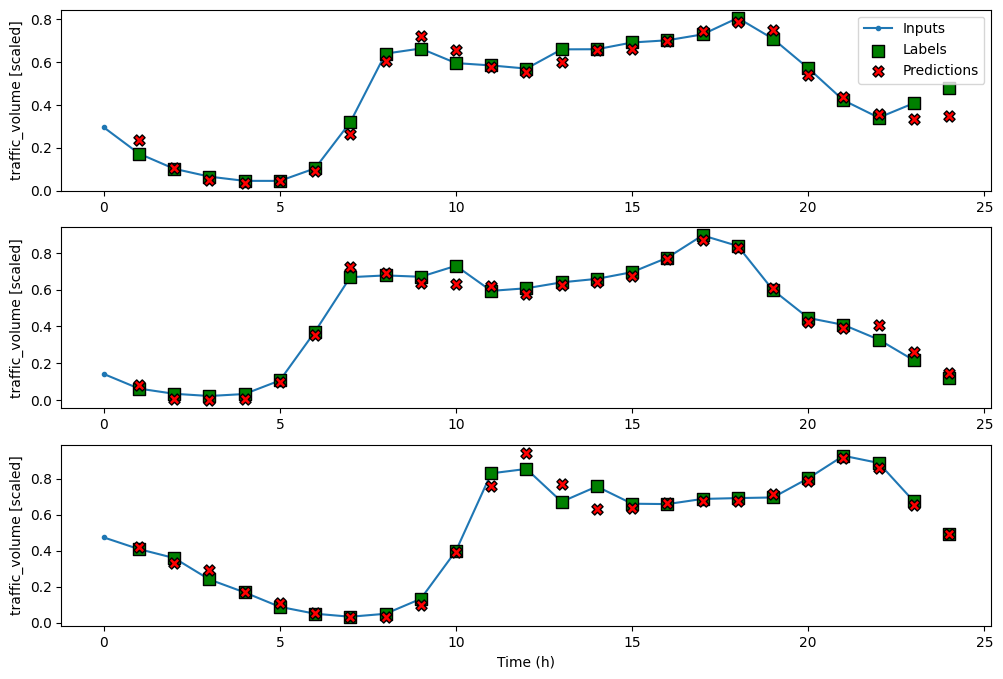

In [17]:
wide_window.plot(lstm_model)

We compare the performance of the LSTM model with the baseline, linear, and fully connected neural network models in single step forecast. We can see that the LSTM model performs slightly better than the fully connected neural network.

In [18]:
mae_val = [0.083, 0.068, 0.033]
mae_test = [0.081, 0.068, 0.029]
mae_val.append(val_performance['LSTM'][1])
mae_test.append(performance['LSTM'][1])

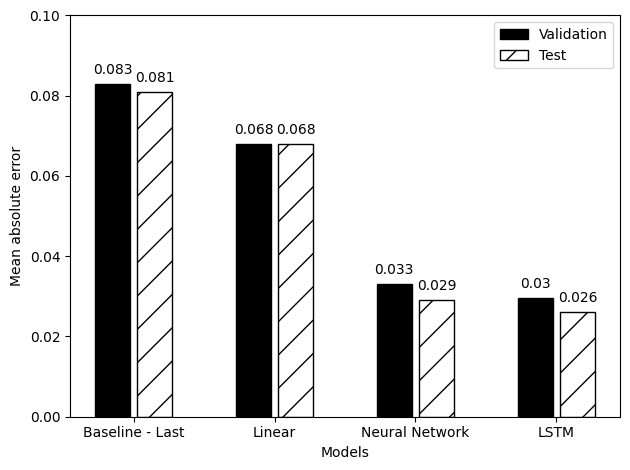

In [20]:
x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Neural Network', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

## Multi-step LSTM model
With this model we want to forecast the traffic volume for the next 24 hours. In this case the LSTM odel is the same as for the single-step forecast but the data window will have a shift set to 24 instead of 1.

In [21]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

In [22]:
ms_lstm_model = keras.Sequential([
    layers.LSTM(32, return_sequences=True),
    layers.Dense(1, kernel_initializer=tf.initializers.zeros),
])

In [23]:
history = compile_and_fit(ms_lstm_model, multi_window)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0898 - mean_absolute_error: 0.2251 - val_loss: 0.0218 - val_mean_absolute_error: 0.1059
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0183 - mean_absolute_error: 0.0958 - val_loss: 0.0176 - val_mean_absolute_error: 0.0886
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 0.0155 - mean_absolute_error: 0.0850 - val_loss: 0.0166 - val_mean_absolute_error: 0.0845
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0146 - mean_absolute_error: 0.0812 - val_loss: 0.0160 - val_mean_absolute_error: 0.0833
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0141 - mean_absolute_error: 0.0794 - val_loss: 0.0160 - val_mean_absolute_error: 0.0810
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0138 - mean_absolute_error: 0.0780 - val_loss: 0.0155 - val_mean_absolute_error: 0.0813
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0136 - mean_absolute_error:

In [24]:
ms_lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 24, 32)              │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 24, 1)               │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,693 (57.40 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,796 (38.27 KB)

In [25]:
ms_val_performance = {}
ms_performance = {}
ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
ms_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0125 - mean_absolute_error: 0.0716


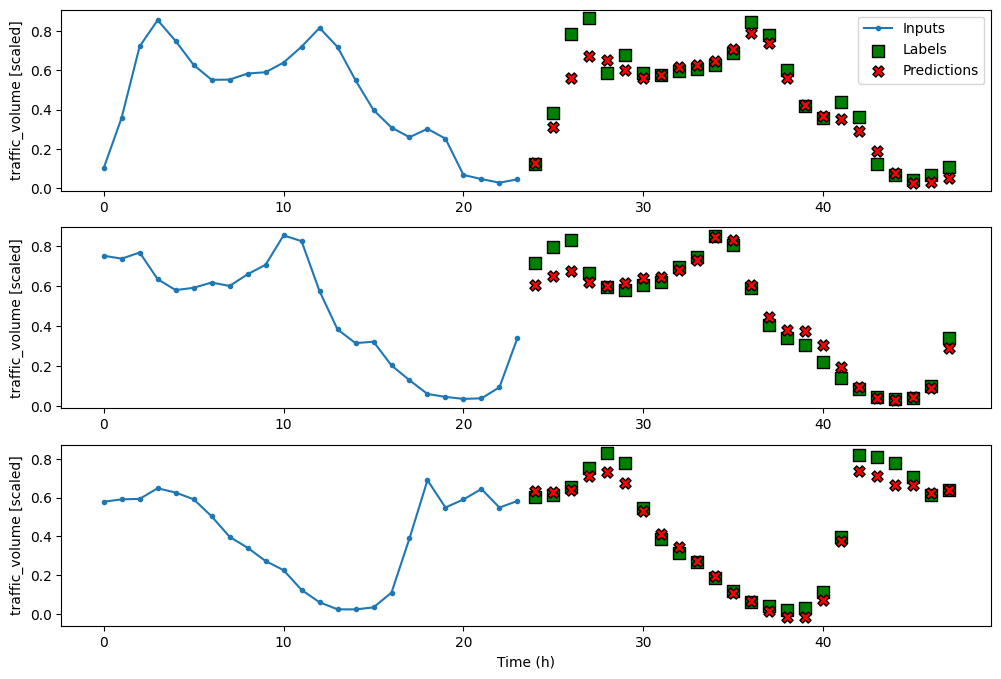

In [26]:
multi_window.plot(ms_lstm_model)

We compare the performance of the LSTM on the multi-step forecast with the performnces of the baseline, linear, and neural network models.

In [27]:
ms_mae_val = [0.352, 0.347, 0.088, 0.078]
ms_mae_test = [0.347, 0.341, 0.076, 0.064]
ms_mae_val.append(ms_val_performance['LSTM'][1])
ms_mae_test.append(ms_performance['LSTM'][1])

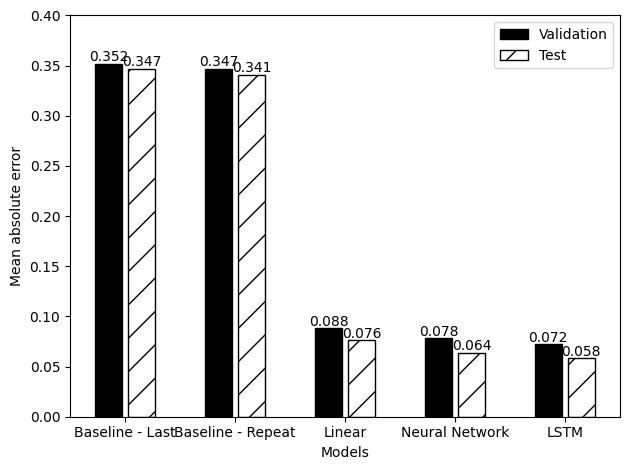

In [28]:
x = np.arange(5)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Neural Network', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

## Multi-output single-step LSTM model

## References
* [Colah - Understanding LSTM networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [Karpathy - The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)